# Tutorial

This tutorial demonstrates how to use LineageVI for RNA velocity analysis with gene programs.


In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import lineagevi
import scanpy as sc
import scvelo as scv
import numpy as np
import os

In [99]:
adata = scv.datasets.pancreas()

In [100]:
adata.X = adata.layers['unspliced'].copy() + adata.layers['spliced'].copy()
adata.layers['counts'] = adata.X.copy()

In [101]:
annotation_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/inputs/gene_sets/'
annotation_name = 'msigdb_development_or_pancreas.gmt'
file_path = os.path.join(annotation_path, annotation_name)
lineagevi.utils.add_annotations(
    adata, 
    files=[file_path],
    min_genes=12,
    varm_key='I',
    uns_key='terms',
    clean=True,
    genes_use_upper=True)

adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [102]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True, log=True)

Filtered out 8545 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [103]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=100)
sc.pp.neighbors(adata, n_neighbors=30)
scv.pp.moments(adata, n_neighbors=30)
sc.pp.scale(adata, layer='Mu')
sc.pp.scale(adata, layer='Ms')

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Filter out any annotations (terms) with less than 12 genes.

In [104]:
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out genes not present in any retained terms after selection of HVGs.

In [105]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [106]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20 + 1, metric='euclidean', n_jobs=-1)
nbrs.fit(adata.obsm['X_pca'])
distances, indices = nbrs.kneighbors(adata.obsm['X_pca'])

adata.uns['indices'] = indices

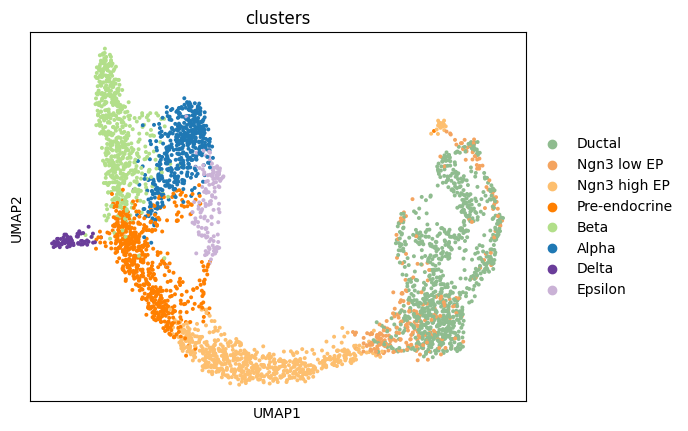

In [107]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

In [138]:
vae = lineagevi.LineageVI(
    adata=adata,
    n_hidden=128,
    mask_key='I',
    unspliced_key='Mu',
    spliced_key='Ms',
    latent_key='z',
    nn_key='indices',
)

history = vae.fit(
    K=10,
    batch_size=1024,
    lr=1e-3,
    epochs1=5,
    epochs2=5,
    seeds=(0, 1, 2),
    output_dir='/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas',   # or None
    verbose=1,
    monitor_genes=['Gnas'],
    monitor_negative_velo=False
)

[Regime1] Epoch 1/5 - Loss: 3.1175
[Regime1] Epoch 2/5 - Loss: 3.0718
[Regime1] Epoch 3/5 - Loss: 3.0089
[Regime1] Epoch 4/5 - Loss: 2.9197
[Regime1] Epoch 5/5 - Loss: 2.8036
[Regime2] Epoch 1/5 - Velocity Loss: 0.5806
[Regime2] Epoch 2/5 - Velocity Loss: 0.5221
[Regime2] Epoch 3/5 - Velocity Loss: 0.4768
[Regime2] Epoch 4/5 - Velocity Loss: 0.4443
[Regime2] Epoch 5/5 - Velocity Loss: 0.4222
Saved model  → /Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas/vae_velocity_model.pt
Note: Call model.get_model_outputs() to annotate adata with velocities


In [109]:
vae.get_model_outputs(
    adata=adata,
    n_samples=100,
    return_mean=True,
    return_negative_velo=True,
    base_seed=0,
    save_to_adata=True,
    unspliced_key='Mu',
    spliced_key='Ms',
    latent_key='z',
    nn_key='indices'
)

computing velocity graph (using 1/10 cores)
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib

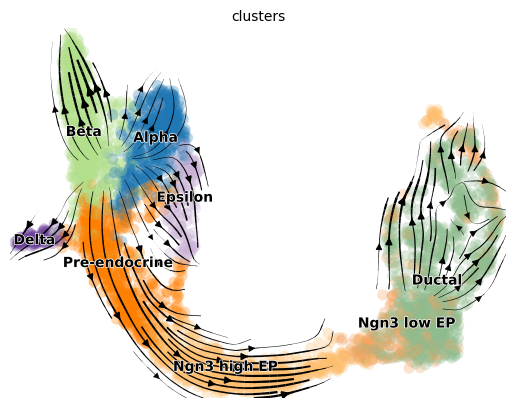

In [110]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

In [111]:
adata_gp = lineagevi.utils.build_gp_adata(adata)

computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


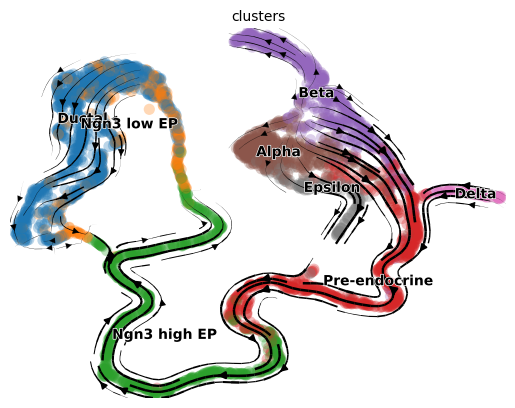

In [112]:
sc.pp.neighbors(adata_gp)
sc.tl.umap(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

In [113]:
vae.map_velocities(
        adata,
        adata_gp=None,
        direction = "gp_to_gene",
        scale = 10.0,
        velocity_key = "velocity_gp2gene",
        unspliced_key = "Mu",
        spliced_key = "Ms"
)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/tools/velocity_graph.py:114: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(adata)
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


In [114]:
vae.map_velocities(
        adata,
        adata_gp=adata_gp,
        direction = "gene_to_gp",
        scale = 10.0,
        velocity_key = "velocity_gene2gp",
        unspliced_key = "Mu",
        spliced_key = "Ms"
)

In [115]:
lineagevi.plots.top_features_table(adata, groupby_key="clusters", categories=['Beta'], layer="velocity", n=10)

,feature,mean_activation,Beta mean
1,Vps8,1.686768,1.686768
2,Cib2,1.552572,1.552572
3,Stxbp5,1.510969,1.510969
4,Ldlrad4,1.500592,1.500592
5,Robo1,1.499629,1.499629
6,Ppp2r2b,1.462827,1.462827
7,Tssc4,1.454118,1.454118
8,Nucb2,1.439107,1.439107
9,Mtus2,1.429899,1.429899
10,Cdh23,1.427052,1.427052


In [116]:
lineagevi.plots.top_features_table(adata_gp, groupby_key="clusters", categories=["Ductal", 'Beta'], layer="velocity", n=10)

,feature,mean_activation,Ductal mean,Beta mean
1,BLOOD_CHAD63_KH_AGE_18_50YO_HI,0.311818,0.182723,0.511903
2,CD69_NEG_VS_POS_TREG_CD62L_LOS-1,0.233939,0.260472,0.192816
3,FETAL_HEART_SATB2_LRRC7_POSITI,0.229208,0.225975,0.234219
4,NAIVE_VS_EFFECTOR_CD8_TCELL_DN,-0.225090,-0.135075,-0.364607
5,STEM_CELL_ADIPOSE_VS_BONE_DN,-0.222821,-0.210718,-0.241578
6,PBMC_FLUARIX_AGE_50_74YO_CORR_-2,-0.221256,-0.158122,-0.319109
7,CYTOKINE_CYTOKINE_RECEPTOR_INT,0.212834,0.117829,0.360086
8,CHRONIC_LYMPHOCYTIC_LEUKEMIA_D,-0.205276,-0.183185,-0.239515
9,OVARIAN_CANCER_GRADES_1_2_UP,-0.203102,-0.192451,-0.219610
10,TREG_VS_TEFF_IN_IL2RB_KO_DN,-0.199532,-0.247260,-0.125557


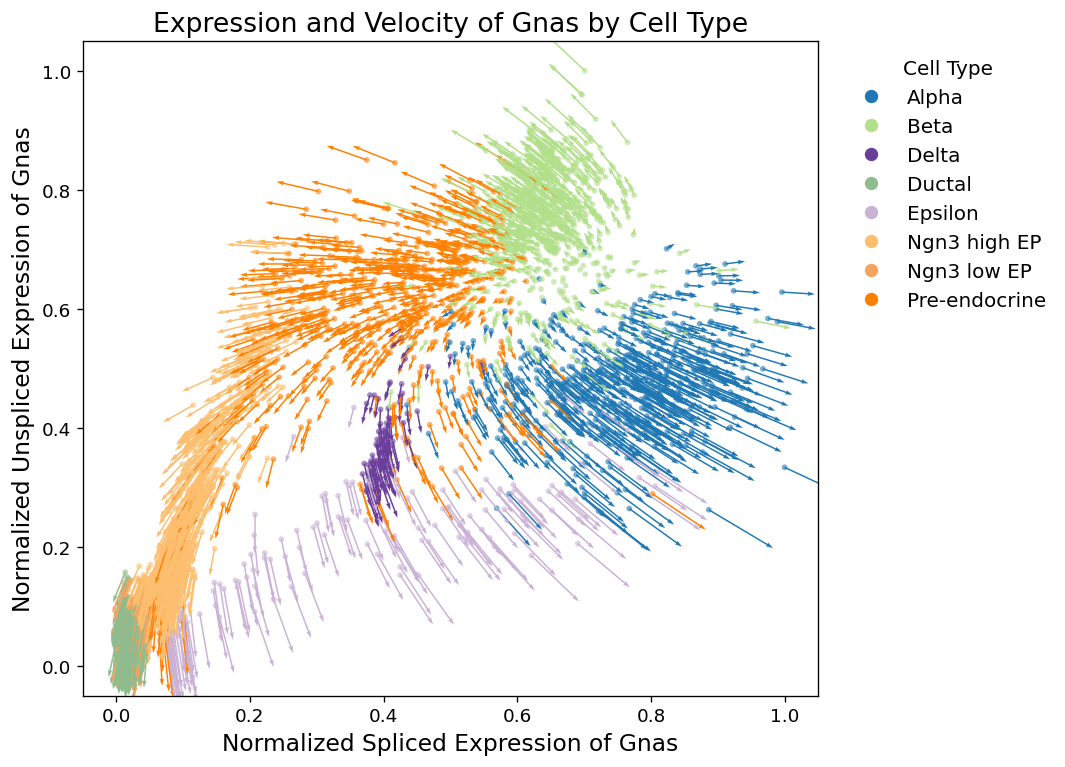

(<Figure size 1080x780 with 1 Axes>,
 <Axes: title={'center': 'Expression and Velocity of Gnas by Cell Type'}, xlabel='Normalized Spliced Expression of Gnas', ylabel='Normalized Unspliced Expression of Gnas'>)

In [117]:
lineagevi.plots.plot_phase_plane(adata, 'Gnas', u_scale=.1, s_scale=.1, alpha=1, head_width=0.02, head_length=0.03, length_includes_head=False)

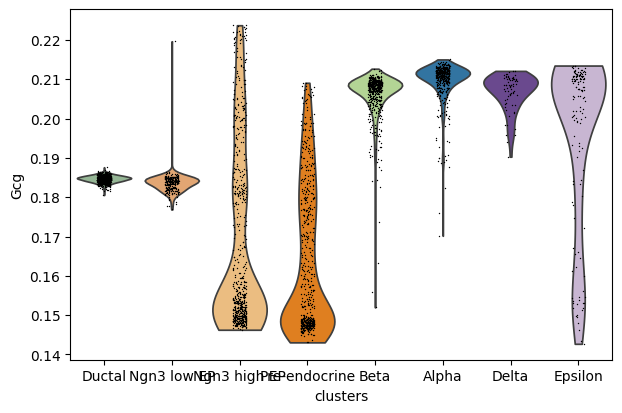

In [118]:
sc.pl.violin(adata, keys='Gcg', layer='alpha', groupby='clusters')

In [119]:
vae.model.latent_enrich(adata, groups='clusters', comparison='rest', n_sample=5000, key_added='bf_scores')

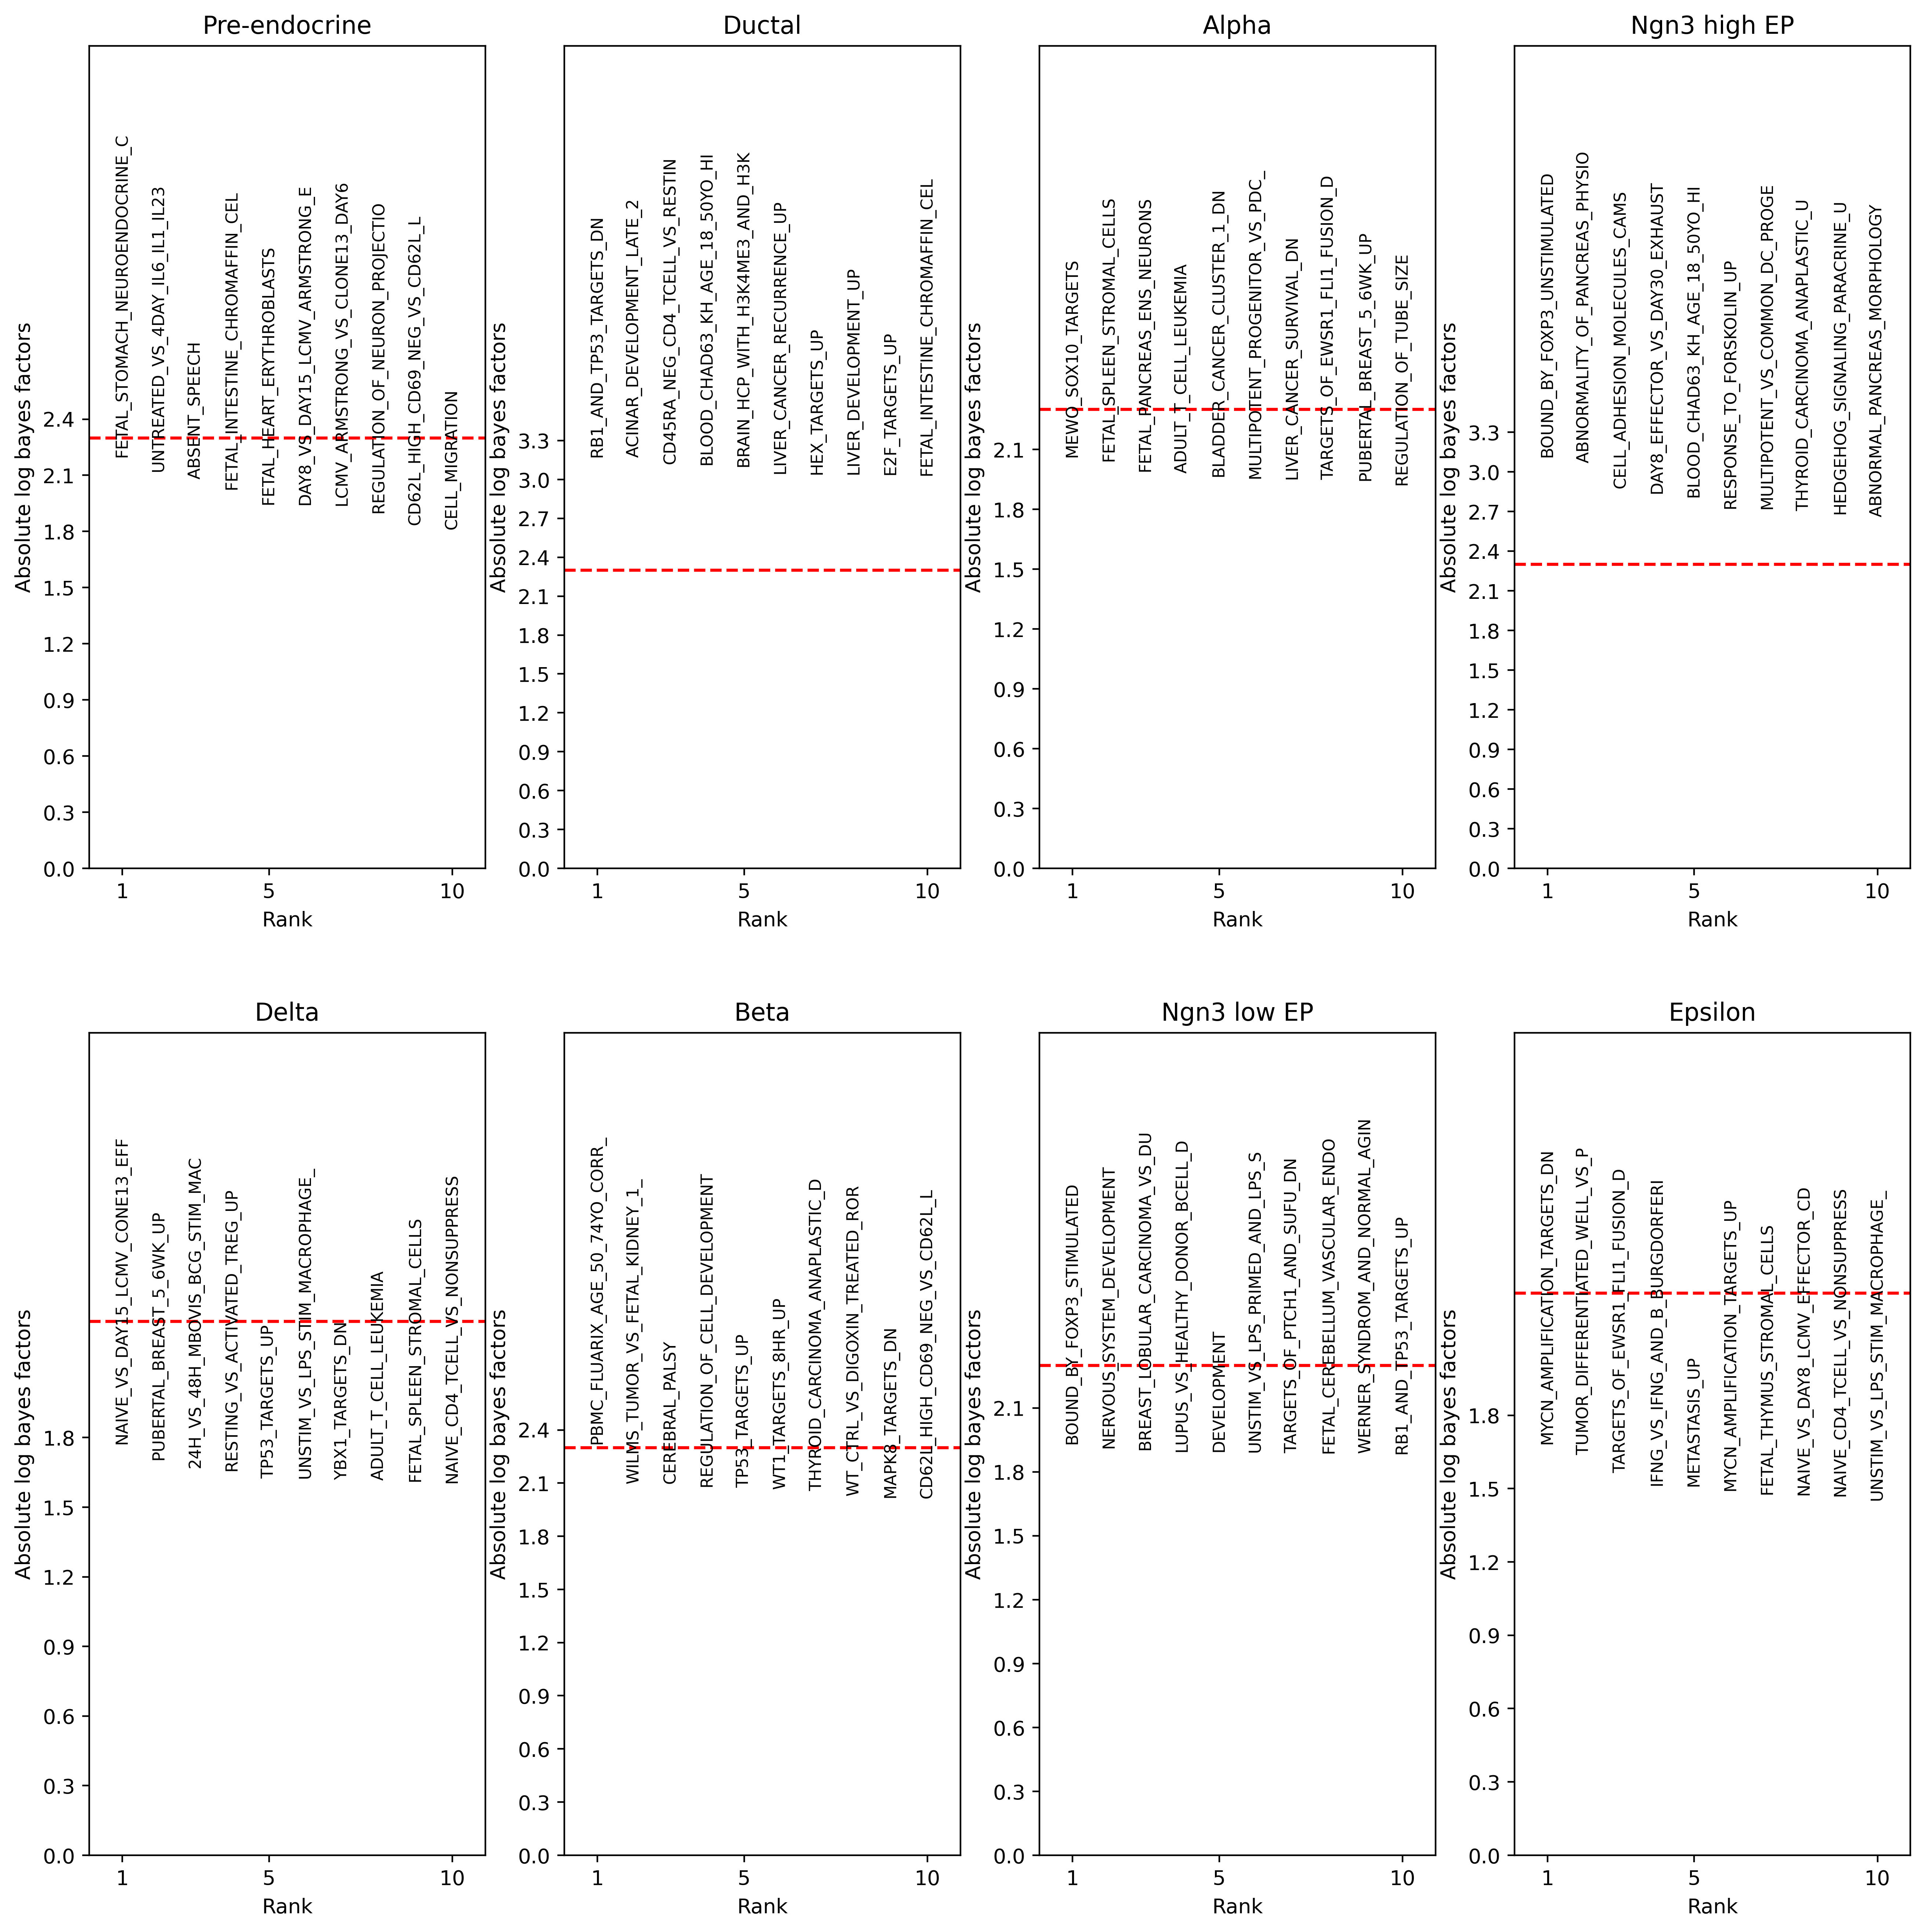

In [120]:
lineagevi.plots.plot_abs_bfs(adata, scores_key='bf_scores', n_cols=4, n_points=10, lim_val=2.3, fontsize=8, scale_y=2, yt_step=0.3,
                    title=None, figsize=None, dpi=400)

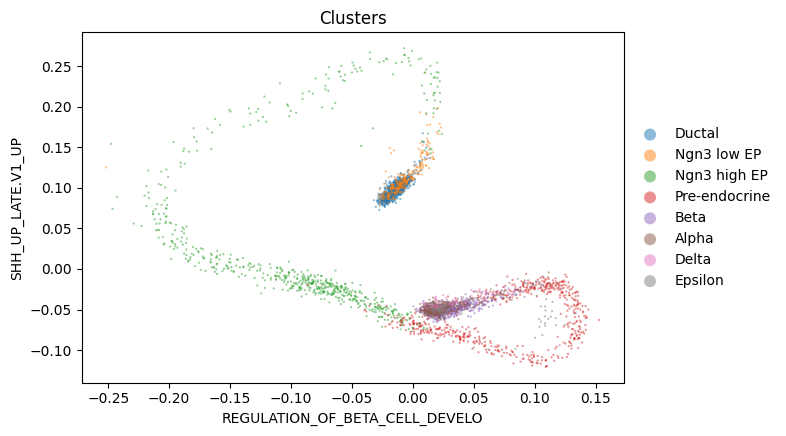

In [121]:
sc.pl.scatter(adata_gp, x='REGULATION_OF_BETA_CELL_DEVELO',y='SHH_UP_LATE.V1_UP', color='clusters', layers='velocity', size=10, alpha=0.5, title='Clusters')

In [122]:
df_genes, df_gps, perturbed_outputs = vae.perturb_genes(
                adata=adata,
                groupby_key='clusters',
                group_to_perturb='Beta',
                genes_to_perturb=['Sntg1', 'Snhg6'],
                perturb_value=0,
                perturb_spliced=True,
                perturb_unspliced=True,
            )


In [123]:
adata.obs['clusters'].value_counts()

clusters
Ductal           916
Ngn3 high EP     642
Pre-endocrine    592
Beta             591
Alpha            481
Ngn3 low EP      262
Epsilon          142
Delta             70
Name: count, dtype: int64

In [124]:
df_genes

,genes,recon_diff,abs_recon_diff,unspliced_velocity_diff,abs_unspliced_velocity_diff,velocity_diff,abs_velocity_diff,alpha_diff,abs_alpha_diff,beta_diff,abs_beta_diff,gamma_diff,abs_gamma_diff
0,Sntg1,0.004802,0.004802,0.870379,0.870379,1.208699,1.208699,-0.000079,0.000079,0.000117,0.000117,-0.001904,0.001904
1,Snhg6,0.000487,0.000487,-0.259117,0.259117,-0.130584,0.130584,-0.000674,0.000674,0.000572,0.000572,-0.000312,0.000312
2,Ncoa2,0.003438,0.003438,0.001062,0.001062,0.002170,0.002170,0.002199,0.002199,-0.001039,0.001039,0.001302,0.001302
3,Sbspon,-0.001280,0.001280,0.000019,0.000019,-0.000612,0.000612,-0.000258,0.000258,0.000474,0.000474,-0.000517,0.000517
4,Pkhd1,-0.003861,0.003861,0.000318,0.000318,-0.000877,0.000877,0.000277,0.000277,-0.000040,0.000040,0.000588,0.000588
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,Rbbp7,-0.001309,0.001309,0.000902,0.000902,0.000723,0.000723,0.001417,0.001417,-0.000082,0.000082,0.000137,0.000137
1991,Ap1s2,0.003316,0.003316,-0.001029,0.001029,-0.000100,0.000100,0.000770,0.000770,0.000890,0.000890,0.002432,0.002432
1992,Gpm6b,0.005411,0.005411,-0.000127,0.000127,-0.000964,0.000964,-0.000073,0.000073,-0.000051,0.000051,-0.001466,0.001466
1993,Uty,-0.000292,0.000292,0.000251,0.000251,0.000188,0.000188,0.000358,0.000358,0.001376,0.001376,0.001775,0.001775


In [125]:
df_gps

,terms,mean_diff,abs_mean_diff,logvar_diff,abs_logvar_diff,gp_velocity_diff,abs_gp_velocity_diff
0,RESPONSE_TO_LPS_WITH_MECHANICA,0.000033,0.000033,0.000569,0.000569,-0.003061,0.003061
1,YBX1_TARGETS_DN,-0.001003,0.001003,0.000989,0.000989,-0.000876,0.000876
2,YBX1_TARGETS_UP,-0.001023,0.001023,-0.001482,0.001482,-0.000420,0.000420
3,CD40_SIGNALING_UP,-0.002261,0.002261,-0.003972,0.003972,0.001491,0.001491
4,CTNNB1_ONCOGENIC_SIGNATURE,-0.002205,0.002205,0.001586,0.001586,-0.000345,0.000345
...,...,...,...,...,...,...,...
684,HEDGEHOG_SIGNALING_PARACRINE_D,-0.000973,0.000973,0.001612,0.001612,-0.002465,0.002465
685,HEDGEHOG_SIGNALING_PARACRINE_U,-0.003886,0.003886,0.000727,0.000727,0.001606,0.001606
686,MAPK8_TARGETS_DN,-0.001704,0.001704,0.000311,0.000311,0.000543,0.000543
687,MAPK8_TARGETS_UP,0.001667,0.001667,0.003095,0.003095,0.000565,0.000565


In [126]:
for key, value in perturbed_outputs.items():
    print(key)
    print('---')

recon
---
mean
---
logvar
---
velocity_gp
---
velo_u_pert
---
velo_pert
---
alpha_pert
---
beta_pert
---
gamma_pert
---


In [127]:
df_genes, df_gps, perturbed_outputs = vae.perturb_gps(
                adata=adata,
                gp_uns_key='terms',
                gps_to_perturb=['YBX1_TARGETS_DN', 'YBX1_TARGETS_UP'],
                groupby_key='clusters',
                group_to_perturb='Beta',
                perturb_value=0
            )

In [128]:
df_genes

,genes,velo_diff_u,abs_velo_diff_u,velo_diff_s,abs_velo_diff_s,x_dec_diff,x_dec_diff_abs,alpha_diff,alpha_diff_abs,beta_diff,beta_diff_abs,gamma_diff,gamma_diff_abs
0,Sntg1,0.002673,0.002673,-0.002724,0.002724,0.0,0.0,0.000442,0.000442,-0.001508,0.001508,0.000310,0.000310
1,Snhg6,-0.001142,0.001142,0.001327,0.001327,0.0,0.0,-0.000829,0.000829,-0.000465,0.000465,0.000925,0.000925
2,Ncoa2,-0.002306,0.002306,0.002736,0.002736,0.0,0.0,-0.001384,0.001384,0.002514,0.002514,-0.002647,0.002647
3,Sbspon,0.000731,0.000731,-0.001581,0.001581,0.0,0.0,-0.000496,0.000496,0.002003,0.002003,-0.000525,0.000525
4,Pkhd1,0.000395,0.000395,0.000678,0.000678,0.0,0.0,0.000600,0.000600,-0.000377,0.000377,0.001234,0.001234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,Rbbp7,0.001569,0.001569,0.001045,0.001045,0.0,0.0,0.001155,0.001155,0.001264,0.001264,0.002318,0.002318
1991,Ap1s2,-0.000553,0.000553,0.000594,0.000594,0.0,0.0,0.000133,0.000133,0.000584,0.000584,0.000161,0.000161
1992,Gpm6b,0.000675,0.000675,0.000403,0.000403,0.0,0.0,0.000475,0.000475,0.000300,0.000300,0.000860,0.000860
1993,Uty,0.000263,0.000263,0.000338,0.000338,0.0,0.0,0.000238,0.000238,-0.000210,0.000210,-0.001587,0.001587


In [129]:
df_gps

,gene_programs,velo_gp,abs_velo_gp
0,RESPONSE_TO_LPS_WITH_MECHANICA,0.002917,0.002917
1,YBX1_TARGETS_DN,0.003990,0.003990
2,YBX1_TARGETS_UP,0.003103,0.003103
3,CD40_SIGNALING_UP,-0.003375,-0.003375
4,CTNNB1_ONCOGENIC_SIGNATURE,-0.003744,-0.003744
...,...,...,...
684,HEDGEHOG_SIGNALING_PARACRINE_D,-0.001388,-0.001388
685,HEDGEHOG_SIGNALING_PARACRINE_U,-0.002861,-0.002861
686,MAPK8_TARGETS_DN,0.000910,0.000910
687,MAPK8_TARGETS_UP,-0.006328,-0.006328


In [130]:
for key, value in perturbed_outputs.items():
    print(key)
    print('---')


velocity_gp_pert
---
velo_u_pert
---
velo_pert
---
alpha_pert
---
beta_pert
---
gamma_pert
---
recon
---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 2028 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2572 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  1.1min


Adding directional_variance to adata.obs
Adding directional_difference to adata.obs
Adding directional_cosine_sim_variance to adata.obs
Adding directional_cosine_sim_difference to adata.obs
Adding directional_cosine_sim_mean to adata.obs
Plotting directional_cosine_sim_variance


[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:  1.3min finished


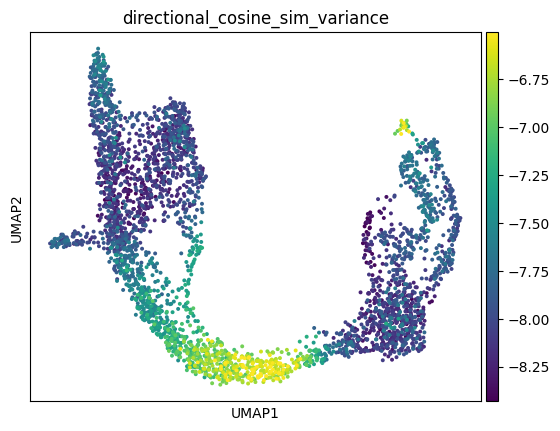

(                  directional_variance  directional_difference  \
 index                                                            
 AAACCTGAGAGGGATA              0.000010                0.009464   
 AAACCTGAGCCTTGAT              0.000007                0.008826   
 AAACCTGAGGCAATTA              0.000011                0.010690   
 AAACCTGCATCATCCC              0.000014                0.011760   
 AAACCTGGTAAGTGGC              0.000017                0.013462   
 ...                                ...                     ...   
 TTTGTCAAGTGACATA              0.000016                0.012191   
 TTTGTCAAGTGTGGCA              0.000028                0.016562   
 TTTGTCAGTTGTTTGG              0.000010                0.009801   
 TTTGTCATCGAATGCT              0.000014                0.012762   
 TTTGTCATCTGTTTGT              0.000008                0.007920   
 
                   directional_cosine_sim_variance  \
 index                                               
 AAACCTGAGAGGGATA  

In [131]:
vae.get_directional_uncertainty(
    adata,
    use_gp_velo = False,
    n_samples = 50,
    n_jobs = -1,
    show_plot =  True,
    base_seed = None,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 964 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2244 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 3076 tasks      | elapsed:   31.7s


Adding directional_variance to adata.obs
Adding directional_difference to adata.obs
Adding directional_cosine_sim_variance to adata.obs
Adding directional_cosine_sim_difference to adata.obs
Adding directional_cosine_sim_mean to adata.obs
Plotting directional_cosine_sim_variance


[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:   38.5s finished


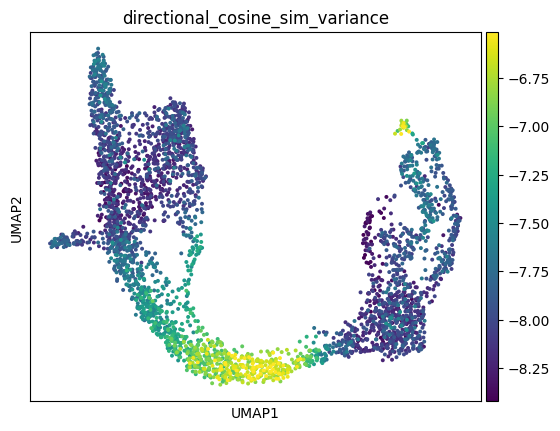

(                  directional_variance  directional_difference  \
 index                                                            
 AAACCTGAGAGGGATA              0.000010                0.009583   
 AAACCTGAGCCTTGAT              0.000008                0.009619   
 AAACCTGAGGCAATTA              0.000008                0.009263   
 AAACCTGCATCATCCC              0.000013                0.010692   
 AAACCTGGTAAGTGGC              0.000029                0.017245   
 ...                                ...                     ...   
 TTTGTCAAGTGACATA              0.000015                0.012495   
 TTTGTCAAGTGTGGCA              0.000036                0.017553   
 TTTGTCAGTTGTTTGG              0.000013                0.010542   
 TTTGTCATCGAATGCT              0.000016                0.011948   
 TTTGTCATCTGTTTGT              0.000009                0.009632   
 
                   directional_cosine_sim_variance  \
 index                                               
 AAACCTGAGAGGGATA  

In [132]:
vae.get_directional_uncertainty(
    adata,
    use_gp_velo = False,
    n_samples = 50,
    n_jobs = -1,
    show_plot =  True,
    base_seed = None,
)

/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/tools/velocity_graph.py:114: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(adata)
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 1380 tasks

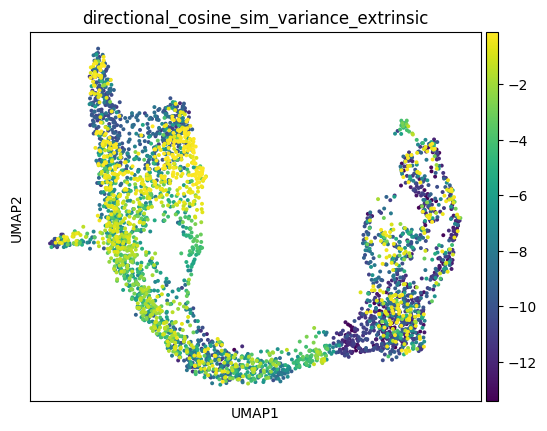

In [135]:
df = vae.compute_extrinsic_uncertainty(
    adata,
    use_gp_velo=True,
    n_samples=25, 
    n_jobs=-1,
    show_plot=True)

/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/tools/velocity_graph.py:114: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(adata)
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 964 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1540 tasks

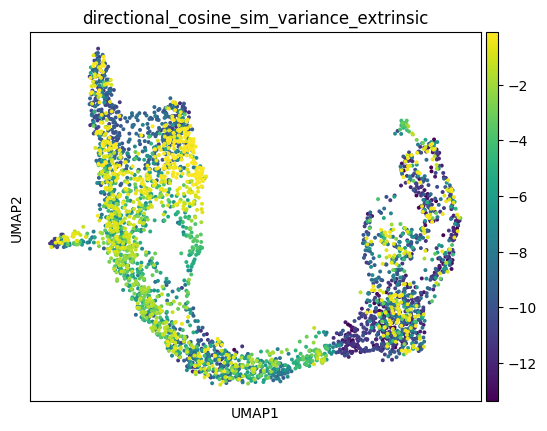

In [136]:
df = vae.compute_extrinsic_uncertainty(
    adata,
    use_gp_velo=True,
    n_samples=25, 
    n_jobs=-1,
    show_plot=True)